1. Imports and Drive Mount

In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


Mounted Drive

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2. Paths and Hyperparameters

In [3]:

DATA_DIR = "/content/drive/My Drive/PROJECT1/data/data_set_20_20_60"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_HEAD = 15
EPOCHS_FINE = 25
CLASS_NAMES = ["Immature", "Mature", "Normal"]

SAVE_DIR_H5 = "/content/drive/My Drive/PROJECT1/trained models/H5"
SAVE_DIR_KERAS = "/content/drive/My Drive/PROJECT1/trained models/keras"
os.makedirs(SAVE_DIR_H5, exist_ok=True)
os.makedirs(SAVE_DIR_KERAS, exist_ok=True)

3. Data Generators and Class Mapping

In [4]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)
valid_data = val_test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "valid"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)
test_data = val_test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "test"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

print("Class indices:", train_data.class_indices)


Found 3712 images belonging to 3 classes.
Found 1237 images belonging to 3 classes.
Found 1237 images belonging to 3 classes.
Class indices: {'Immature': 0, 'Mature': 1, 'Normal': 2}


4. Compute Class Weights

In [5]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))


5. Model Creation and Compilation

In [6]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(len(CLASS_NAMES), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=["accuracy"])


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


6. Callbacks Setup

In [7]:
es = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)


7. Head Training

In [8]:
history_head = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=EPOCHS_HEAD,
    class_weight=class_weights,
    callbacks=[es, rlr]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 2664s 23s/step - accuracy: 0.4365 - loss: 1.2791 - val_accuracy: 0.7494 - val_loss: 0.5963 - learning_rate: 0.0010
Epoch 2/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 51s 439ms/step - accuracy: 0.6912 - loss: 0.7146 - val_accuracy: 0.8027 - val_loss: 0.4618 - learning_rate: 0.0010
Epoch 3/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 48s 417ms/step - accuracy: 0.7546 - loss: 0.5799 - val_accuracy: 0.8715 - val_loss: 0.3908 - learning_rate: 0.0010
Epoch 4/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 49s 418ms/step - accuracy: 0.7870 - loss: 0.5134 - val_accuracy: 0.8286 - val_loss: 0.3798 - learning_rate: 0.0010
Epoch 5/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 50s 427ms/step - accuracy: 0.8024 - loss: 0.4746 - val_accuracy: 0.8230 - val_loss: 0.3675 - learning_rate: 0.0010
Epoch 6/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 49s 423ms/step - accuracy: 0.7966 - loss: 0.4695 - val_accuracy: 0.8909 - val_loss: 0.3101 - learning_rate: 0.0010
Epoch 7/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 48s 409ms/step - accuracy: 0.8

8. Fine-Tuning

In [9]:
for layer in base_model.layers[-50:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

history_fine = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=EPOCHS_FINE,
    class_weight=class_weights,
    callbacks=[es, rlr]
)


Epoch 1/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 91s 572ms/step - accuracy: 0.8647 - loss: 0.3433 - val_accuracy: 0.9386 - val_loss: 0.2049 - learning_rate: 1.0000e-05
Epoch 2/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 47s 407ms/step - accuracy: 0.8740 - loss: 0.3117 - val_accuracy: 0.9434 - val_loss: 0.1857 - learning_rate: 1.0000e-05
Epoch 3/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 47s 406ms/step - accuracy: 0.8830 - loss: 0.2939 - val_accuracy: 0.9563 - val_loss: 0.1642 - learning_rate: 1.0000e-05
Epoch 4/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 48s 410ms/step - accuracy: 0.8889 - loss: 0.2713 - val_accuracy: 0.9531 - val_loss: 0.1550 - learning_rate: 1.0000e-05
Epoch 5/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 48s 412ms/step - accuracy: 0.8930 - loss: 0.2543 - val_accuracy: 0.9555 - val_loss: 0.1451 - learning_rate: 1.0000e-05
Epoch 6/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 48s 411ms/step - accuracy: 0.9059 - loss: 0.2490 - val_accuracy: 0.9580 - val_loss: 0.1354 - learning_rate: 1.0000e-05
Epoch 7/25
116/116 ━━━━━━━━━━━━━━━━━━━━ 47s 40

9. Evaluation and Save Model

In [10]:
loss, acc = model.evaluate(test_data)
accuracy_str = f"{acc*100:.2f}".replace(".", "_")
model_name_h5 = f"densenet121({accuracy_str}).h5"
model_name_keras = f"densenet121({accuracy_str}).keras"

model.save(os.path.join(SAVE_DIR_H5, model_name_h5))
model.save(os.path.join(SAVE_DIR_KERAS, model_name_keras))

print(f"Test accuracy: {acc*100:.2f}%")
print(f"Models saved as:\n{model_name_h5}\n{model_name_keras}")


39/39 ━━━━━━━━━━━━━━━━━━━━ 828s 22s/step - accuracy: 0.9843 - loss: 0.0563


Test accuracy: 99.19%
Models saved as:
densenet121(99_19).h5
densenet121(99_19).keras


10. Plot Training History

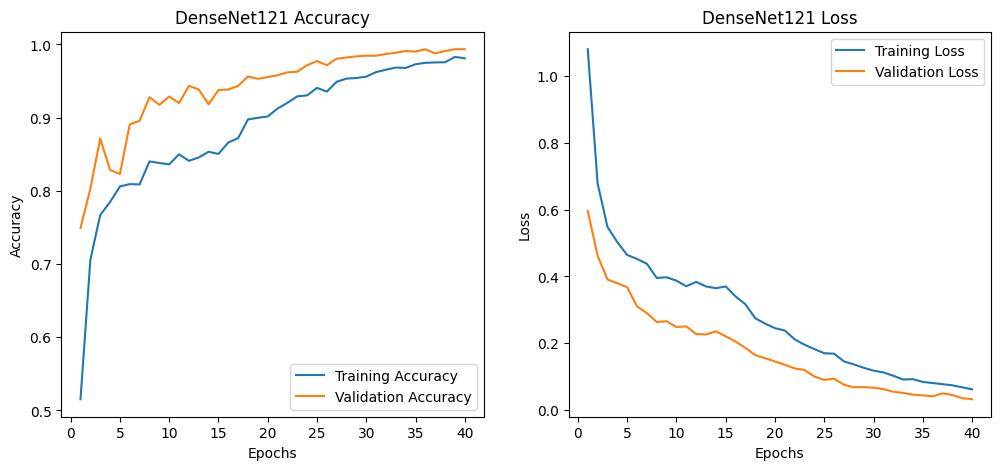

In [11]:
def plot_training(history_head, history_fine, model_name="DenseNet121"):
    acc = history_head.history['accuracy'] + history_fine.history['accuracy']
    val_acc = history_head.history['val_accuracy'] + history_fine.history['val_accuracy']
    loss = history_head.history['loss'] + history_fine.history['loss']
    val_loss = history_head.history['val_loss'] + history_fine.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training(history_head, history_fine, model_name="DenseNet121")


39/39 ━━━━━━━━━━━━━━━━━━━━ 25s 380ms/step


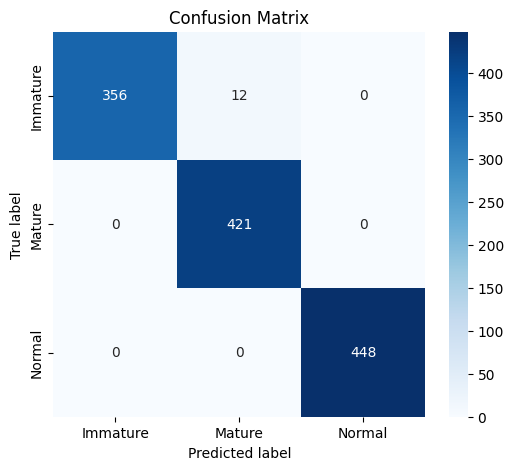

              precision    recall  f1-score   support

    Immature       1.00      0.97      0.98       368
      Mature       0.97      1.00      0.99       421
      Normal       1.00      1.00      1.00       448

    accuracy                           0.99      1237
   macro avg       0.99      0.99      0.99      1237
weighted avg       0.99      0.99      0.99      1237



In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get ground-truth labels and predictions for test set
test_steps = test_data.samples // test_data.batch_size + int(test_data.samples % test_data.batch_size != 0)
y_true = test_data.classes
y_pred_probs = model.predict(test_data, steps=test_steps, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
label_names = list(test_data.class_indices.keys())

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report for precision, recall, f1-score
print(classification_report(y_true, y_pred, target_names=label_names))
